In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import skorch

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torchvision

In [4]:
def sg(x):
    """ stop gradinet function from the paper """
    return Variable(x.data)

In [117]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim, latent_dim):
        super().__init__()
        self.l0 = nn.Linear(input_size, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, latent_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        l0 = self.l0(x)
        l0 = self.act(l0)
        l1 = self.l1(l0)
        l1 = self.act(l1)
        return l1

In [118]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.l0 = nn.Linear(latent_dim, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        l0 = self.l0(x)
        l0 = self.act(l0)
        l1 = self.l1(l0)
        return torch.nn.functional.sigmoid(l1)

In [241]:
class Discretizer(nn.Module):
    def __init__(self, num_latents, hidden_dim):
        super().__init__()
        self.num_latents = num_latents
        self.hidden_dim = hidden_dim
        #self.e = nn.Parameter(torch.zeros((num_latents, hidden_dim)))
        self.e = nn.Parameter(torch.randn((num_latents, hidden_dim)) * 0.02)

    def distance(self, a, b):
        return ((a - b)**2).sum(dim=-1).sqrt()

    def forward(self, z_e):       
        #return z_e
        return Variable(z_e.data, requires_grad=True)
        
        # compute min distance between z_e and self.e for each row in z_e,
        # return matrix with (_, e_{best match for each row})

        # to find the embedding row of self.e that matches best with the input
        # for each row in the input z_e, we first have to align both tensors.
        z_e_exp = z_e.repeat(1, self.e.size(0)).view(z_e.size(0) * self.e.size(0), -1)
        e_exp = self.e.repeat(z_e.size(0), 1)
        d = self.distance(z_e_exp, e_exp)

        d = d.view(z_e.size(0), self.e.size(0))

        _min_dists, idx = d.min(-1)
        #print(_min_dists)

        return self.e[idx]
    
        # if we would return e[idx] directly then the gradient would propagate 
        # from the decoder's output to self.e (the discrete embeddings), however
        # the paper implements changing self.e by compoting L2(sg(z_e) - e[idx])
        # so we return sg(self.e[idx]) instead...
        return Variable(self.e[idx].data, requires_grad=True)

In [242]:
class VQVAE(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_latents, latent_dim):
            super().__init__()
            self.enc = Encoder(input_dim, hidden_dim, latent_dim)
            self.dis = Discretizer(num_latents, latent_dim)
            self.dec = Decoder(latent_dim, hidden_dim, input_dim)

        def forward(self, x):
            z_e = self.enc(x)
            e_k = self.dis(z_e)
            z_q = self.dec(e_k)
            return z_q, z_e, e_k

In [243]:
MNIST = torchvision.datasets.MNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [244]:
train_loader = lambda _ds, **kwargs: torch.utils.data.DataLoader(MNIST, **kwargs)

In [419]:
class Trainer(skorch.NeuralNet):
        def __init__(self, beta=0.25, criterion=nn.MSELoss, *args, **kwargs):
            self.beta = beta
            super().__init__(*args, criterion=criterion, **kwargs)
            
        def initialize_module(self, *args, **kwargs):
            r = super().initialize_module(*args, **kwargs)
            
            #self.module_.enc.l0.weight.register_hook(lambda grad: print('l0grad',grad))
            #self.module_.enc.l1.weight.register_hook(lambda grad: print('l1grad',grad))
            
            return r
            
        def evaluation_step(self, *args, **kwargs):
            ret = super().evaluation_step(*args, **kwargs)
            return ret[0]

        def train_step(self, X, _, optimizer):
            optimizer.zero_grad()
            
            X = X.view(-1, 28 * 28)
            X = skorch.utils.to_var(X, use_cuda=self.use_cuda)
            y = skorch.utils.to_var(X, use_cuda=self.use_cuda)
            
            z_q, z_e, e_k = self.infer(X)
            
            def l2(x):
                return (x**2).sum().sqrt()

            recon = self.criterion_(z_q, y)
            vq = l2(sg(z_e) - e_k)
            commit = self.beta * l2(z_e - sg(e_k))
            
            # compute reconstruction gradient for later
            # use in the encoder backward-pass.
            e_k.retain_grad()
            recon.backward(retain_graph=True)
            encode_grad = e_k.grad.clone()
            
            #encode_grad = torch.autograd.grad(recon, e_k, retain_graph=True)
                        
            z_e.backward(retain_graph=True, gradient=encode_grad)
            encode_grads = [p.grad.clone() for n, p in self.module_.enc.named_parameters()]
            
            L = recon + vq + commit
            L.backward()
            
            encode_grads_2 = [p.grad.clone() for n, p in self.module_.enc.named_parameters()]
            
            # vq loss backward overwrites gradients of the encoder.
            # we add the encoder gradients determined using reconstruction
            # loss back here.
            for i, (name, p) in enumerate(self.module_.enc.named_parameters()):
                p.grad = encode_grads_2[i] +  encode_grads[i]
                
            # FIXME: p.grad = encode_grads[i] works fine, p.grad = 0*p.grad + encode_grads[i]
            # does not.
                                
            optimizer.step()
            
            return L

In [420]:
torch.manual_seed(42)
ef = Trainer(
    module=VQVAE,
    module__input_dim=28 * 28,
    module__hidden_dim=128,
    module__latent_dim=32,
    module__num_latents=10,
    
    beta=0.25,
    
    optimizer=torch.optim.Adam,
    optimizer__lr=0.004,

    iterator_train=train_loader,
    iterator_train__batch_size=64,
    iterator_train__shuffle=True,
    
    max_epochs=10,
    
    train_split=None,
    
    callbacks=[skorch.callbacks.ProgressBar()],
).initialize()

In [421]:
%pdb on
if False:
    ef.load_params('vqvae.pt')
else:
    ef.fit(np.zeros(1), None)

Automatic pdb calling has been turned ON
Re-initializing module!


Widget Javascript not detected.  It may not be installed or enabled properly.


  epoch    train_loss      dur
-------  ------------  -------
      1        0.8141  19.5076


Widget Javascript not detected.  It may not be installed or enabled properly.


      2        0.8024  21.4323


Widget Javascript not detected.  It may not be installed or enabled properly.


In [422]:
ef.save_params('vqvae.pt')

### Evaluation

In [423]:
num_samples = 10
grid_side = np.ceil(np.sqrt(num_samples))
X_eval = np.array([x.view(28 * 28) for _, (x,y) in zip(range(num_samples), iter(MNIST))])
X_eval_hat = ef.predict_proba(X_eval)

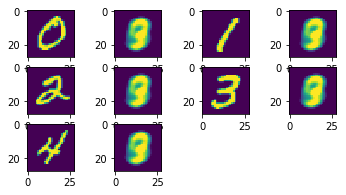

309/|/ 33%|| 309/938 [00:22<00:14, 42.24it/s, train_loss=0.81]

In [424]:
for i in range(1, num_samples, 2):
    plt.subplot(grid_side, grid_side, i)
    plt.imshow(X_eval[i].numpy().reshape(28, 28))
    plt.subplot(grid_side, grid_side, i+1)
    plt.imshow(X_eval_hat[i].reshape(28, 28))

In [295]:
z_q, z_e, e_k = ef.infer(torch.stack(X_eval, dim=0))

209/|/ 22%|| 209/938 [00:20<00:17, 42.48it/s, train_loss=0.8]

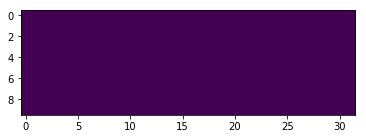

In [160]:
plt.imshow(z_e.data.numpy())

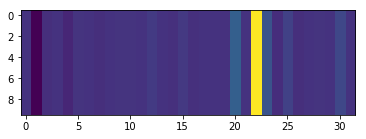

18/|/  2%|| 18/938 [00:13<00:32, 28.23it/s, train_loss=0.837]

In [161]:
plt.imshow(e_k.data.numpy())

### Discrete embedding vectors

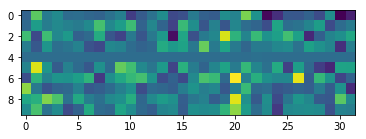

In [162]:
plt.imshow(ef.module_.dis.e.data.numpy())

### Distance between latent vectors

In [163]:
D = np.array([[ef.module_.dis.distance(a,b).data[0] for a in ef.module_.dis.e] 
              for b in ef.module_.dis.e])

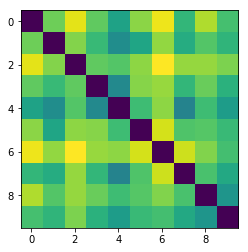

In [164]:
plt.imshow(D)